In [1]:
import numpy as np 

In [2]:
def base_polynomial(x, M=5):
    """
    多項式基底を元にした計画行列の作成
    inputs:
        x : 2d-array. Nxd  = (サンプル数)x(特徴量数)
    return:
        Phi : 2d-array. Nx(Mxd). (1つの特徴量に対してM個の基底関数を適用)
                計画行列を返す
    """
    N = x.shape[0] # サンプル数
    d = x.shape[1] # 特徴量数
    Phi = np.zeros(shape=(N, int(M*d)), dtype='float')
    for m in range(M):
        Phi[:,m::M] = x**m
    return Phi  

In [19]:
a = np.array([1,2])
type(a) == np.ndarray

True

In [20]:
def base_gauss(x, M=5, seed=42, mu=None):
    """
    ガウス基底を元にした計画行列の作成
    inputs:
        x : 2d-array. Nxd  = (サンプル数)x(特徴量数)
    return:
        Phi : 2d-array. Nx(Mxd). (1つの特徴量に対してM個の基底関数を適用)
                計画行列を返す
    今回は簡略化のため、σの値は1で統一する(これは入力が正規化されてるのも理由の1つ)
    """
    np.random.seed(seed)  
    N = x.shape[0]
    d = x.shape[1]
    if type(mu) != np.ndarray:
        mu = np.random.randn(M*d) # 基底関数の数だけ平均値をランダム生成
    else:
        M = mu.shape[0]//d
    x_tile = np.tile(x, (1,M))
    Phi = -(x_tile-mu)**2/2
    return Phi, mu
    

$$
\boldsymbol{m}_N = \boldsymbol{S}_N(\boldsymbol{S}_0^{-1} \boldsymbol{m}_0 + \beta \Phi^T \hat{\boldsymbol{y}}) \\\\
\boldsymbol{S}_N = \boldsymbol{S}_0^{-1} + \beta \Phi^T \Phi \\\\
$$
予測値の分布
$$
p(\hat{y}_{N+1}| \hat{\boldsymbol{y}}, \boldsymbol{X}, \boldsymbol{x}_{N+1}) = \mathcal{N}(\hat{y}_{N+1} | \boldsymbol{m}_N \boldsymbol{\phi}(\boldsymbol{x}_{N+1}), \beta^{-1}+\boldsymbol{\phi}(\boldsymbol{x}_{N+1})^T \boldsymbol{S}_N \boldsymbol{\phi}(\boldsymbol{x}_{N+1}))) \\\\
$$

In [21]:
def bayesian_regression(X, y, base_mode='polynomial',M=5, w_S=None, w_m=None, mu=None,beta=1e0):
    """
    ベイズ推定を行う。
    inputs:
        X : 2d-array(Nxd). 説明変数
        y : 1d-array(N,). 教師データ
        base_mode: {'polynomial', 'gauss'}. 基底関数の種類
        M : 各説明変数に対して何個ずつ基底関数を生成するか.
        mu : ガウス分布を基底関数として使うときの各々の分布の平均値
    return:
        wm_list : 2d-array.((Mxd), 1)のlist. 重みベクトルの期待値のリスト
        wS_list : 2d-array.((Mxd), (Mxd))のlist. 重みベクトルの分散のリスト
        m_list : 2d-array. (N, 1)のlist. 予測値の期待値のリスト
        S_list : 2d-array. (N,N)のlist. 予測値の分散のリスト
    """
    d = X.shape[1]
    N = X.shape[0]
    if not w_S:
        w_S = np.eye(M*d)
    if not w_m:
        w_m = np.zeros(M*d).reshape(-1,1)

    wS_list = []
    wm_list = []
    S_list = []
    m_list = []
    lam = 1e-3 # 逆行列を求める時にエラーを防ぐ
    if base_mode == 'polynomial':
        Phi_all = base_polynomial(X, M)
    elif base_mode == 'gauss':
        Phi_all, mu = base_gauss(X, M, mu=mu)  
    else:
        raise ValueError("Please valid base mode , {'gauss', 'polynomial'}")  
    for i in range(N):
        w_S_0 = w_S +  lam*np.eye(M*d)
        w_m_0 = w_m +  lam*np.ones(M*d).reshape(-1,1)
        if base_mode=='polynomial':
            Phi = base_polynomial(X[i,:].reshape(1,-1),M) 
        elif base_mode == 'gauss':
            Phi, mu = base_gauss(X[i,:].reshape(1,-1), M=M, mu=mu)
        w_S = np.linalg.inv(np.linalg.inv(w_S_0) + beta * np.dot(Phi.T,Phi))
        m_partial_1 = np.dot(np.linalg.inv(w_S_0), w_m_0)
        m_partial_2 = beta * np.dot(Phi.T, y[i].reshape(1,1))
        w_m = w_S.dot(m_partial_1+m_partial_2)
        m = np.dot(Phi_all, w_m)  
        S = beta**(-1) + np.dot(Phi_all, np.dot(w_S, Phi_all.T))  
        wS_list.append(w_S)
        wm_list.append(w_m)
        S_list.append(S)
        m_list.append(m)  
    return wS_list,wm_list,S_list,m_list  

In [33]:
N = 30
X = np.linspace(-4, 4, N).reshape(-1,1)  
y_true = 0.3*np.sin(X)+ 0.4*np.cos(X) 
y = y_true +np.random.randn(N,1)/3.0
X = (X - X.mean(axis=0))/X.std(axis=0)  
y = (y - y.mean())/y.std()
y_true = (y_true - y_true.mean())/y_true.std()
# wS_list,wm_list, S_list, m_list = bayesian_regression(X, y,M=5,beta=1.0) 

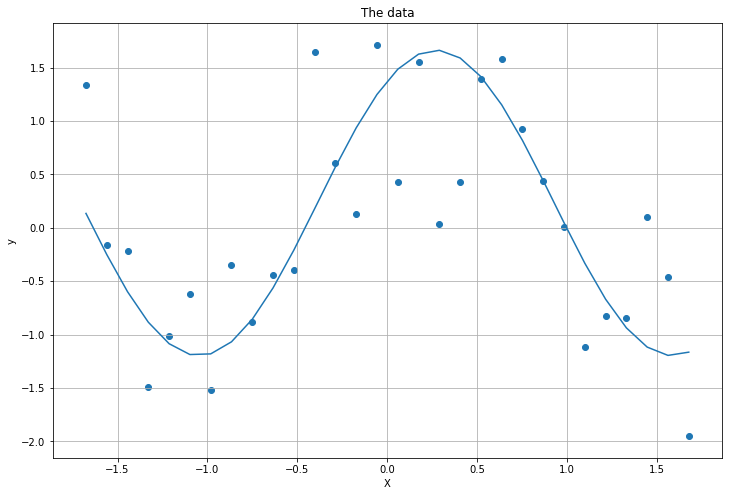

In [43]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12,8))
plt.plot(X.flatten(), y_true.flatten(), label='true_model')
plt.scatter(X.flatten(), y.flatten(), label='raw_data')
plt.title('The data')
plt.xlabel('X')
plt.ylabel('y')
plt.grid()
plt.savefig('fig/show_data.png')
plt.show()

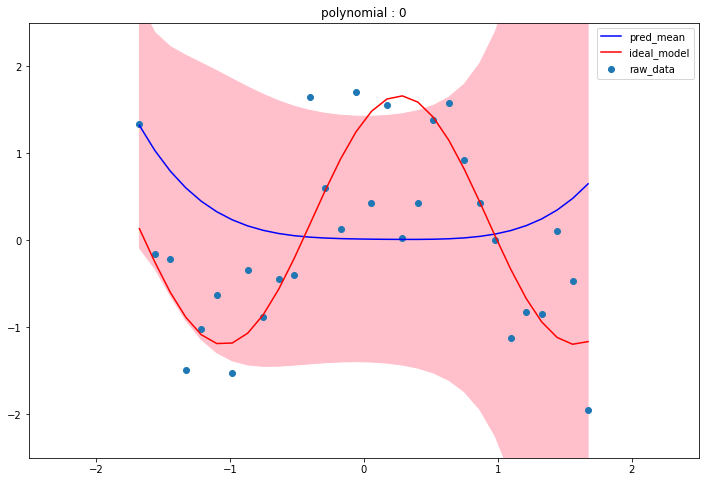

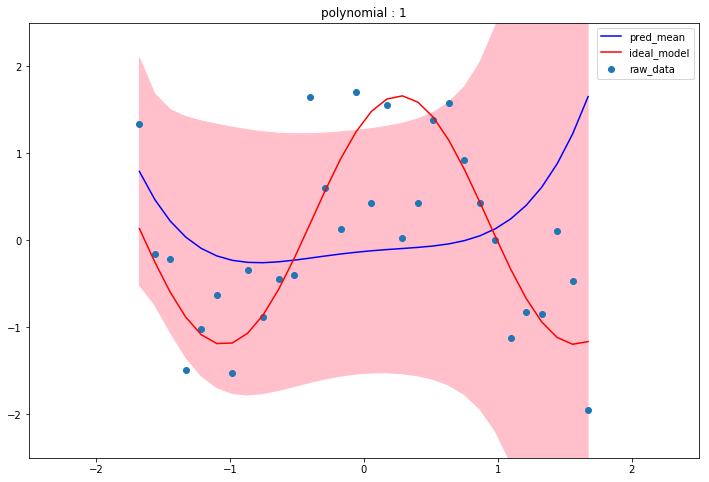

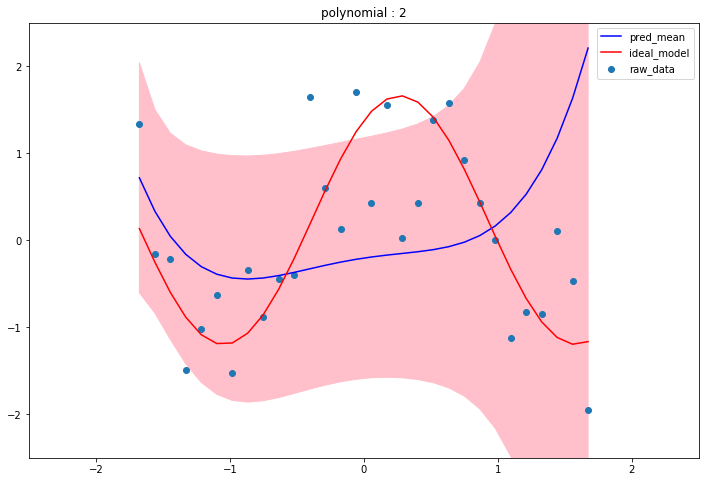

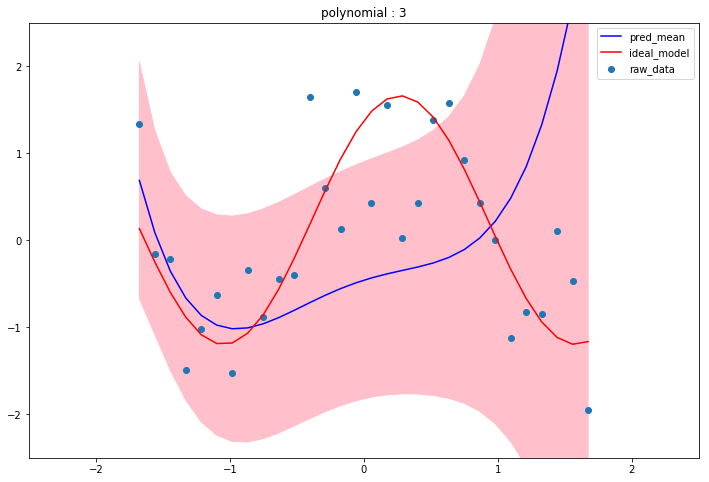

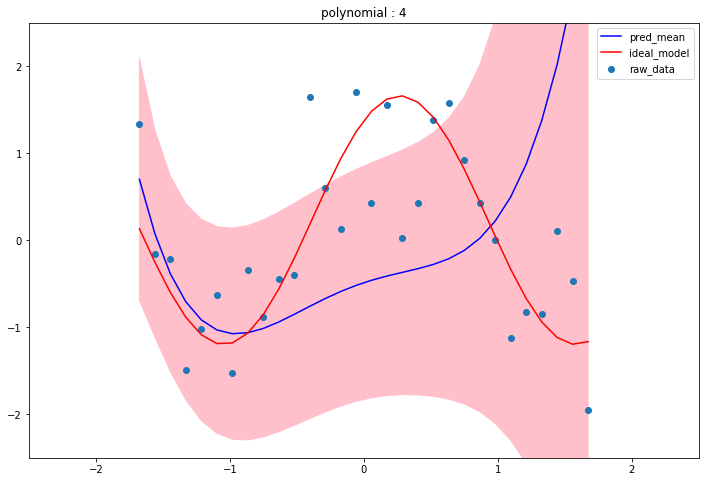

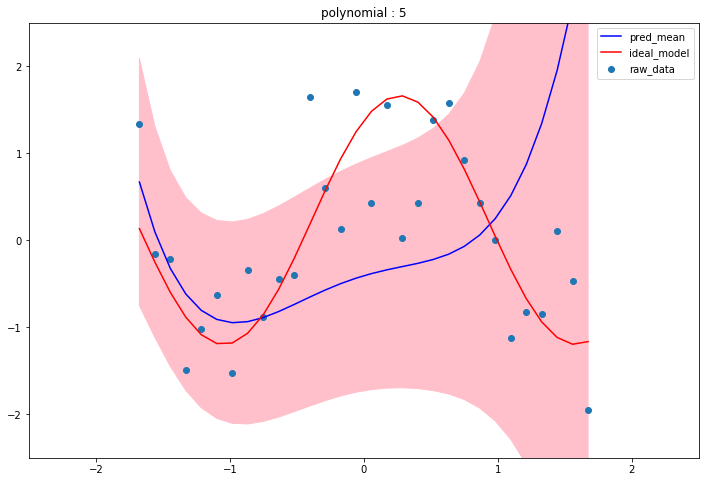

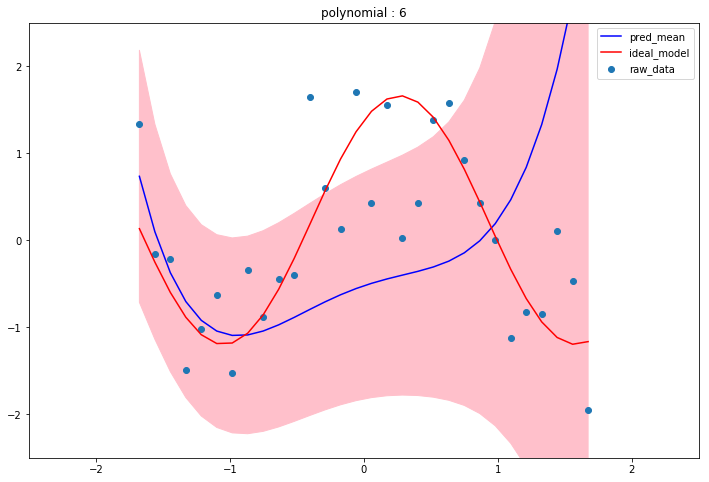

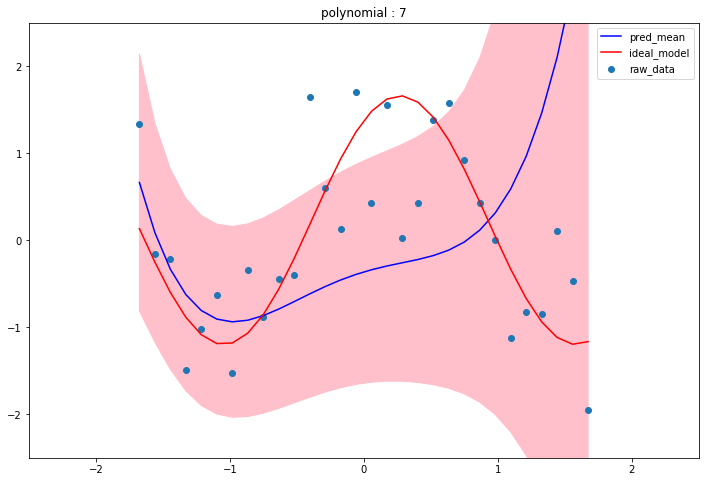

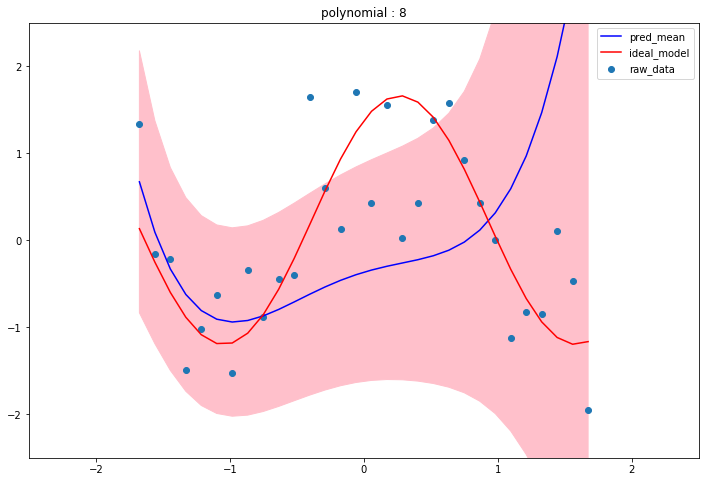

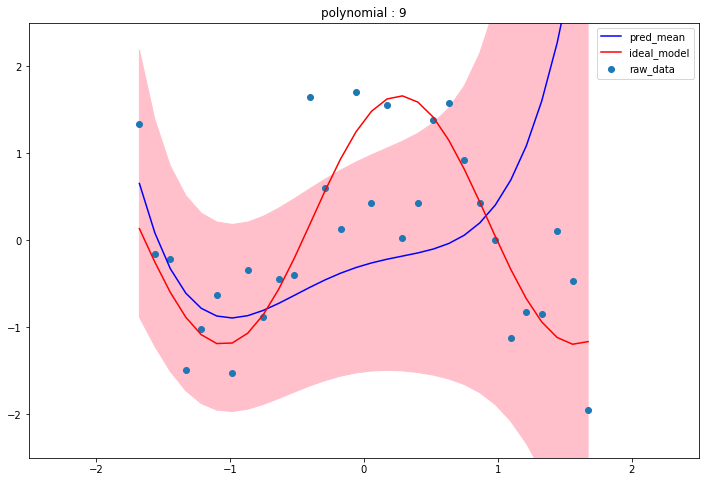

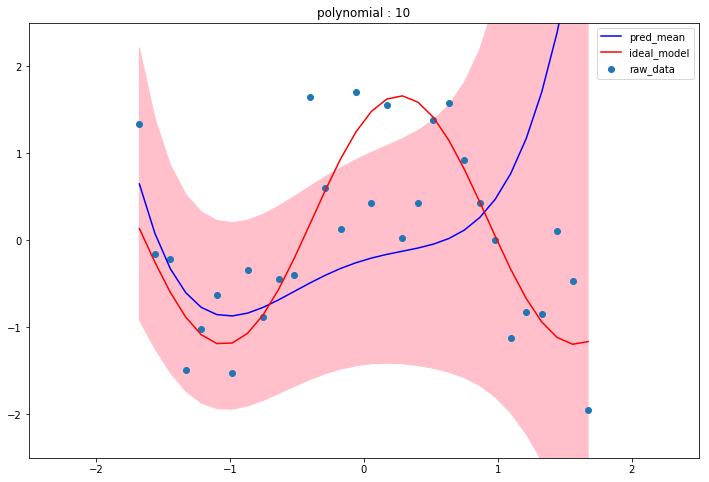

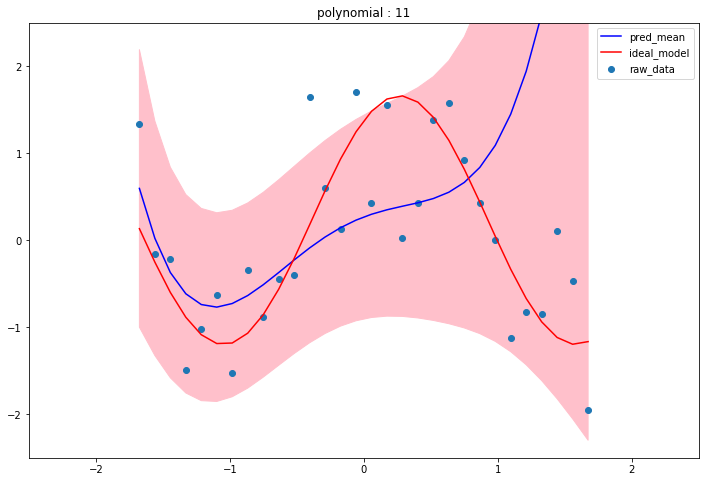

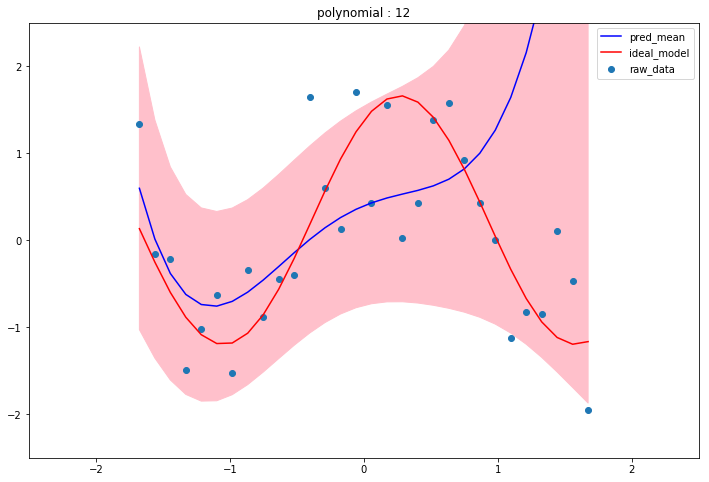

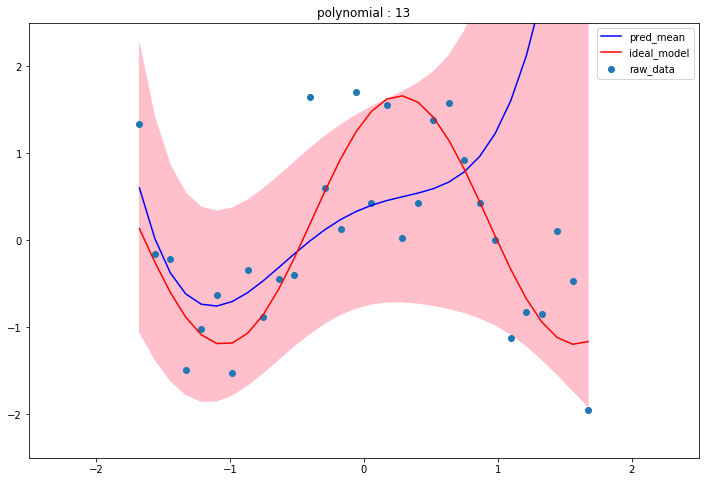

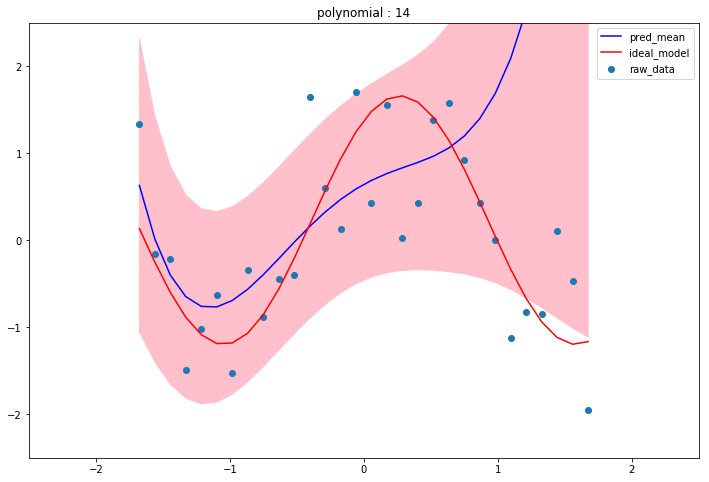

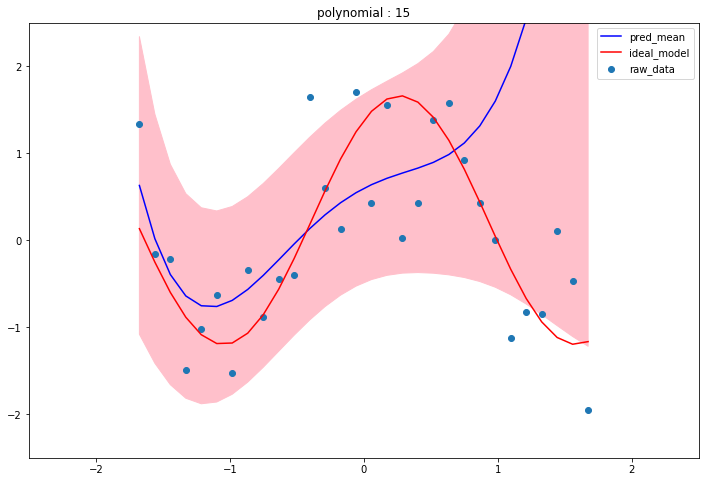

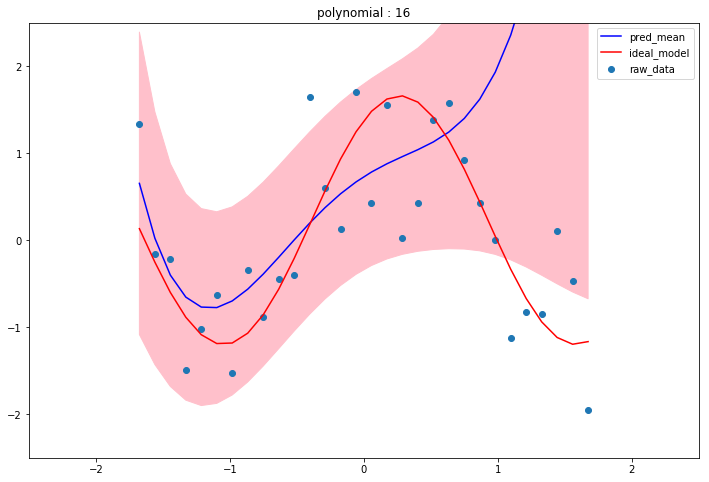

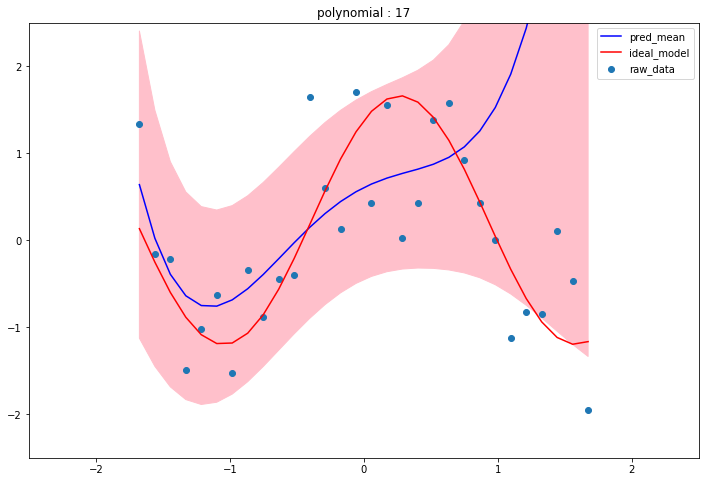

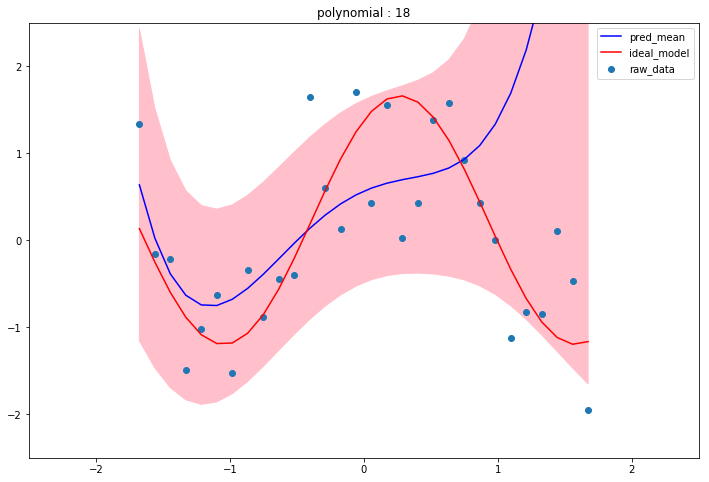

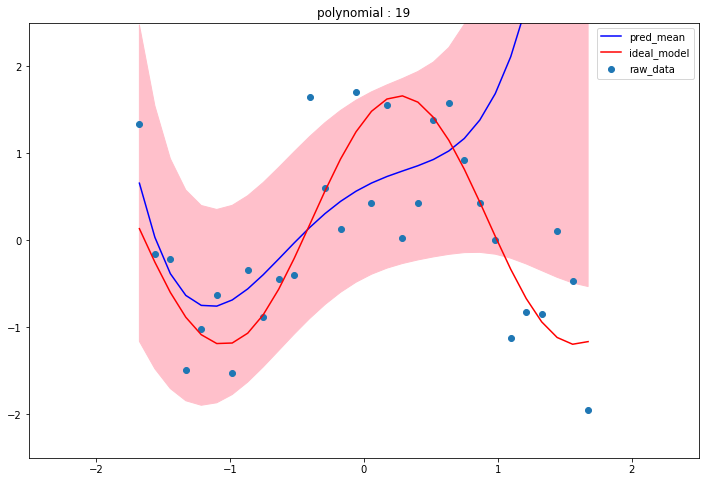

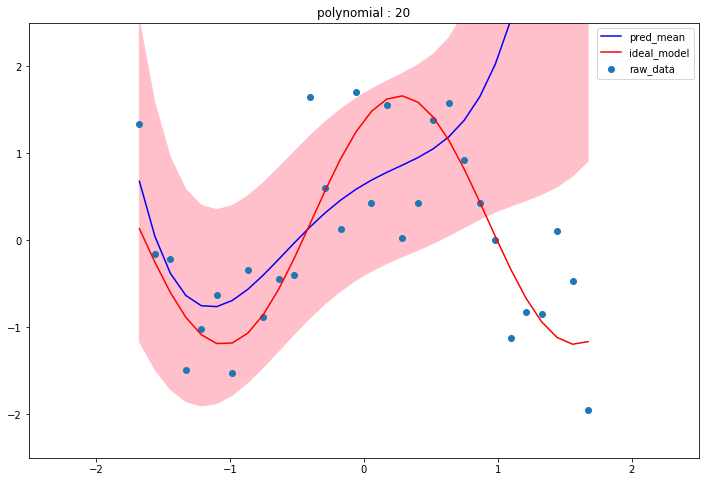

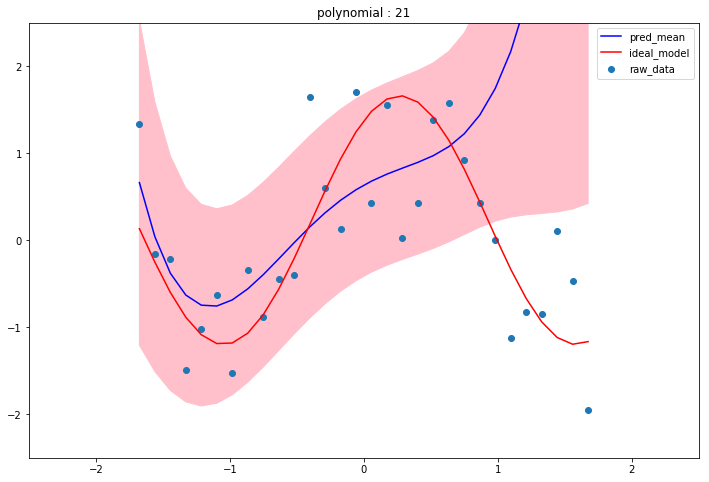

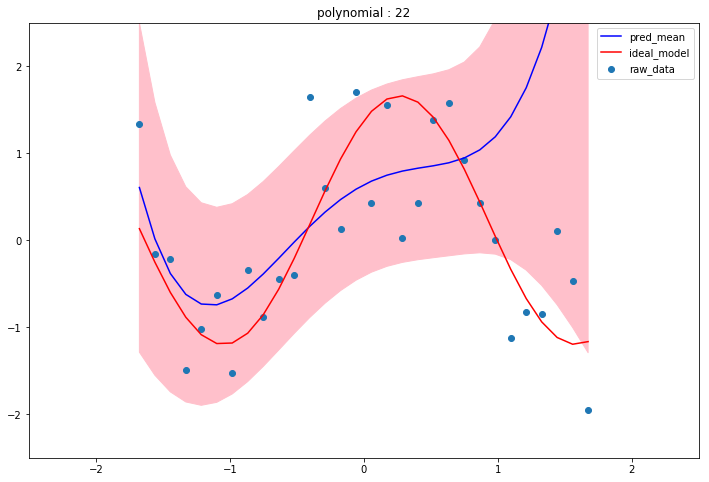

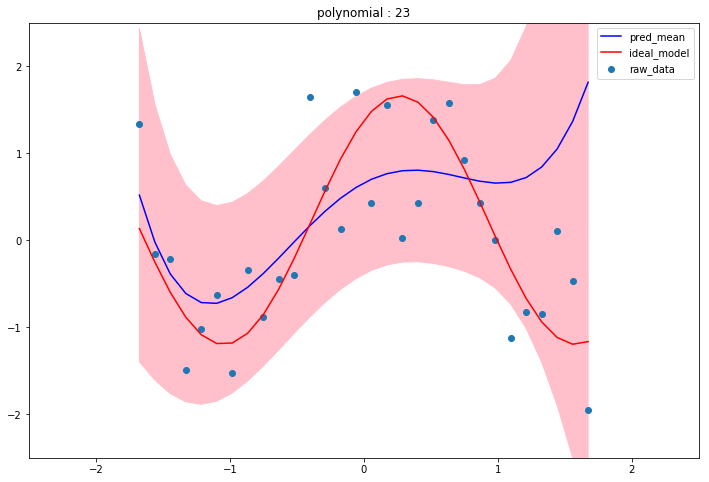

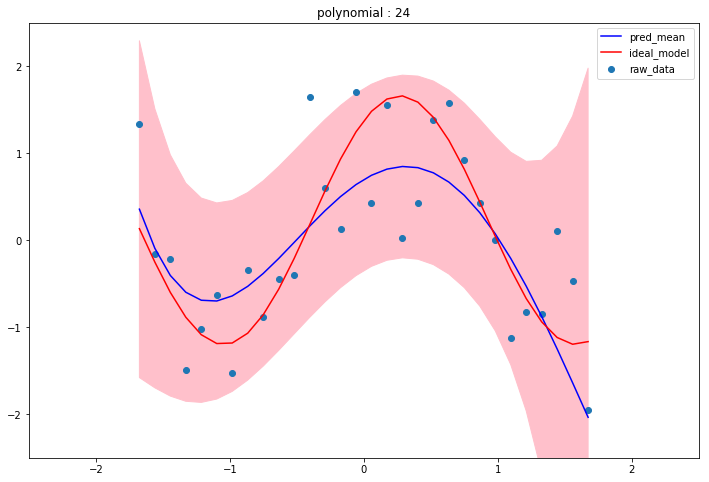

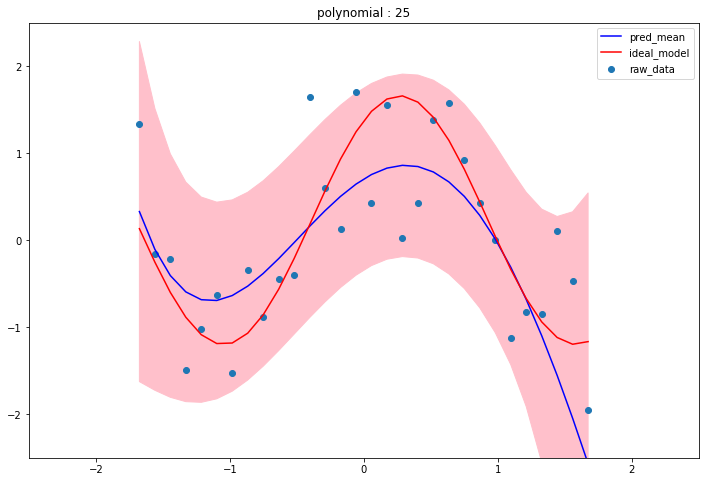

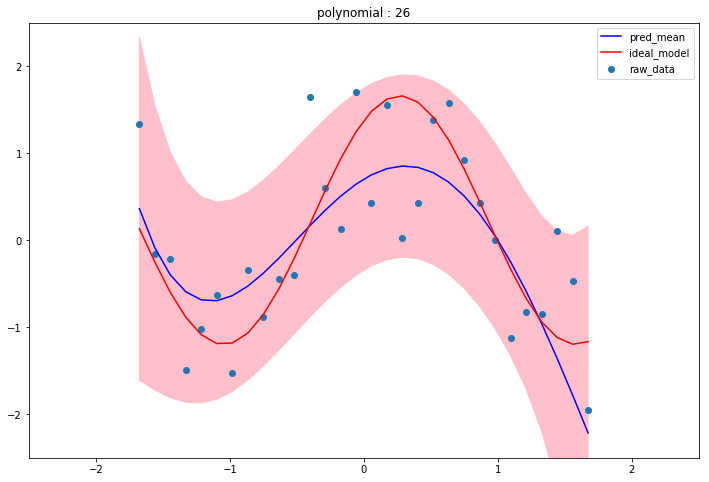

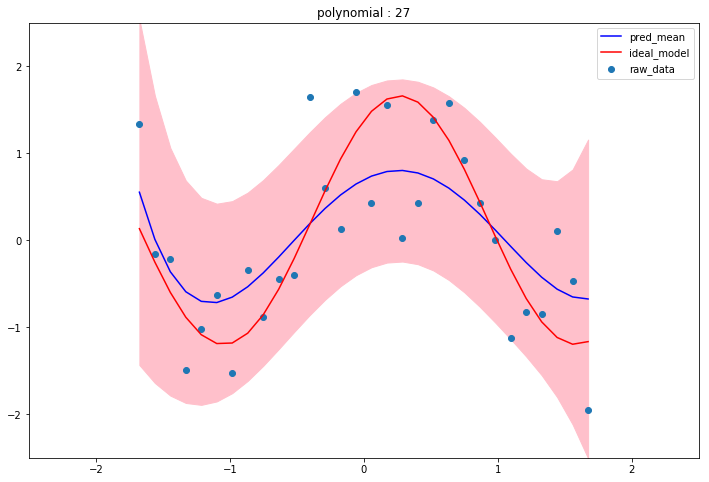

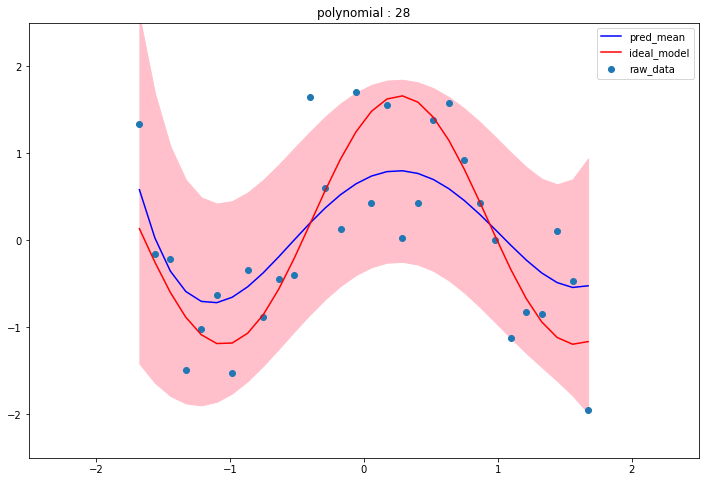

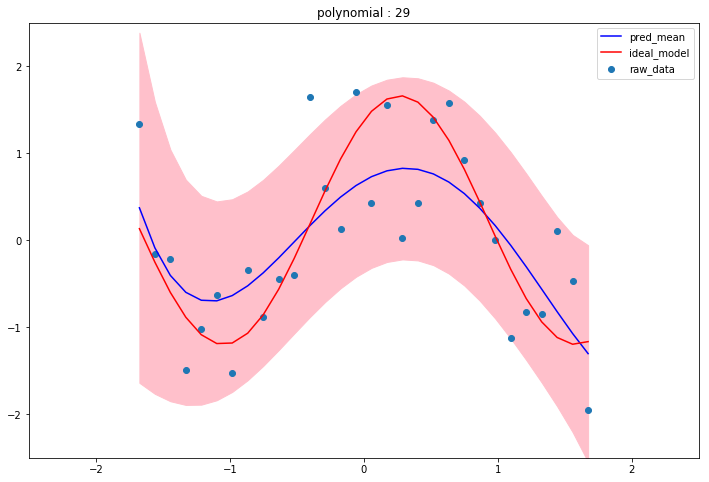

In [44]:
%matplotlib inline 
from matplotlib import pyplot as plt 
# base_modeの指定
mode = 'polynomial'
wS_list,wm_list, S_list, m_list = bayesian_regression(X, y,M=5,beta=1.0,
                                                      base_mode=mode)
for i in range(X.shape[0]):
    plt.figure(figsize=(12,8))
    plt.ylim(-2.5,2.5)
    plt.xlim(-2.5,2.5)
    SD = np.sqrt(np.diag(S_list[i]))
    upper = m_list[i].flatten() + SD.flatten()
    lower = m_list[i].flatten() - SD.flatten()
    # 分布のプロット
    plt.fill_between(X.flatten(), upper.flatten(), lower.flatten(), color='pink')
    # 今回使ったデータのプロット
    plt.scatter(X.flatten(),y.flatten(), label='raw_data')
    # 予測値の平均(期待値)のプロット
    plt.plot(X.flatten(), m_list[i].flatten(), label='pred_mean',color='b')
    # 元々のモデルのプロット  
    plt.plot(X.flatten(), y_true, label='ideal_model', color='r')
    plt.legend()
    plt.title(f'{mode} : {i}')
    plt.savefig(f'fig/bayesian_{mode}_{i}.png')
    

基底関数にガウス関数を使う場合は平均値となる`mu`を等間隔に配置した方が結果の見栄えがよくなる。  


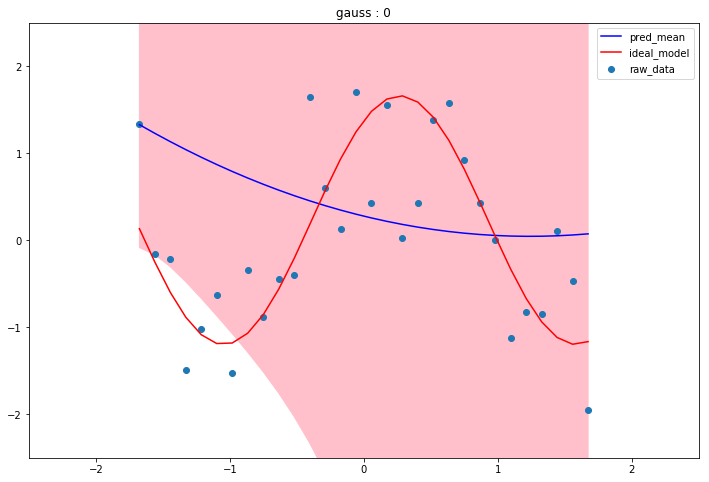

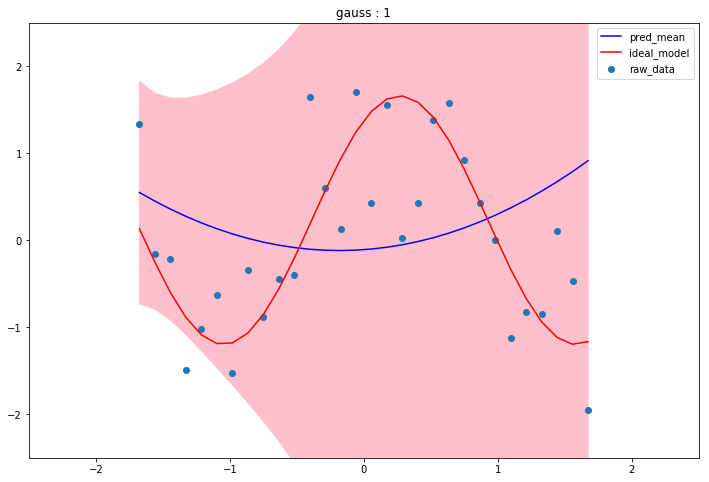

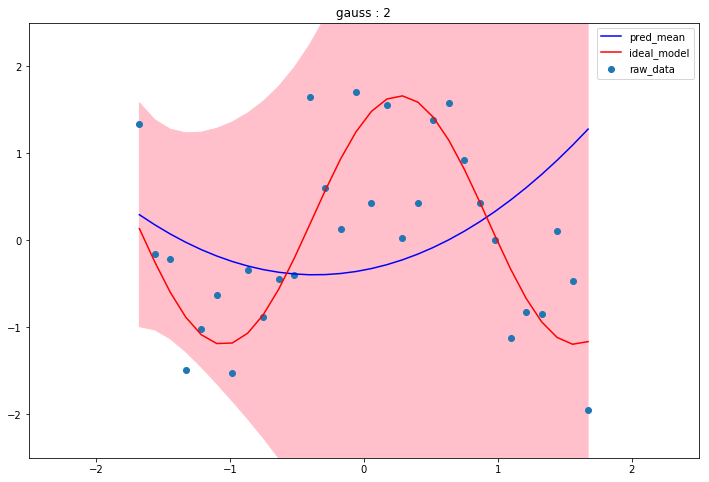

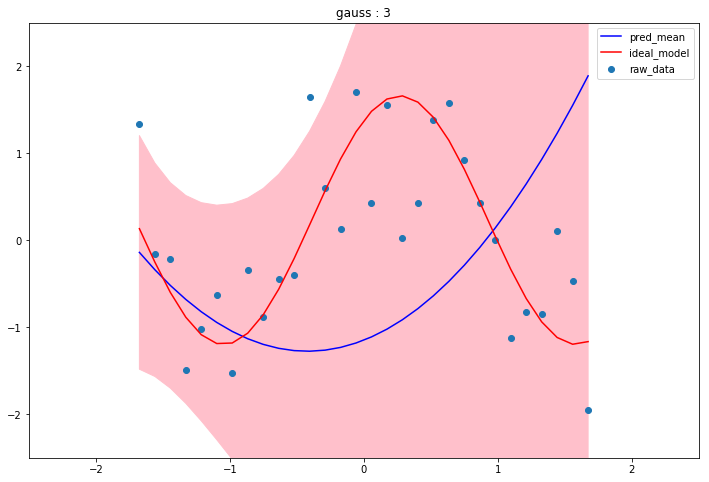

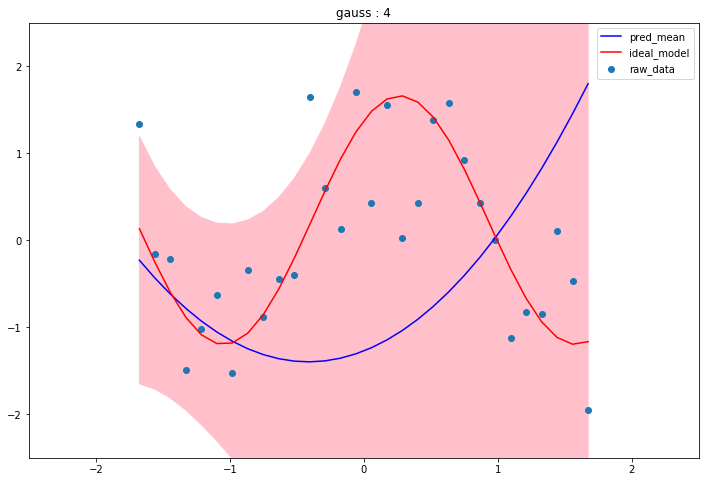

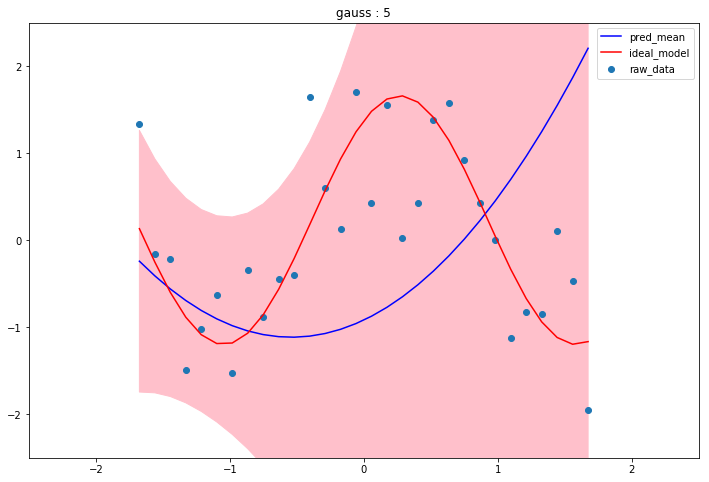

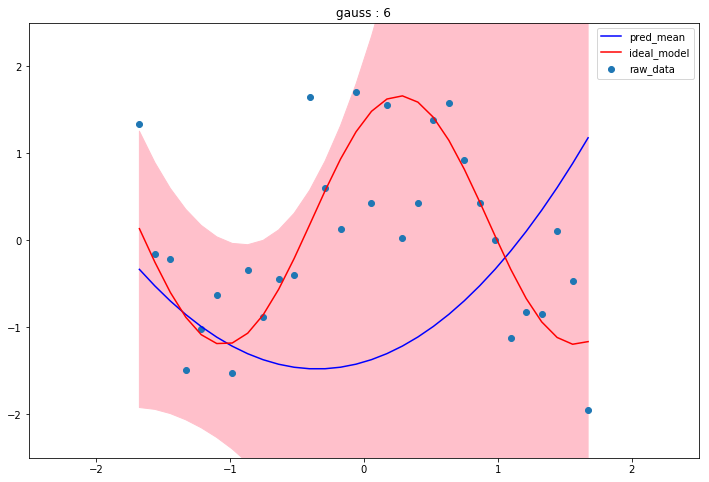

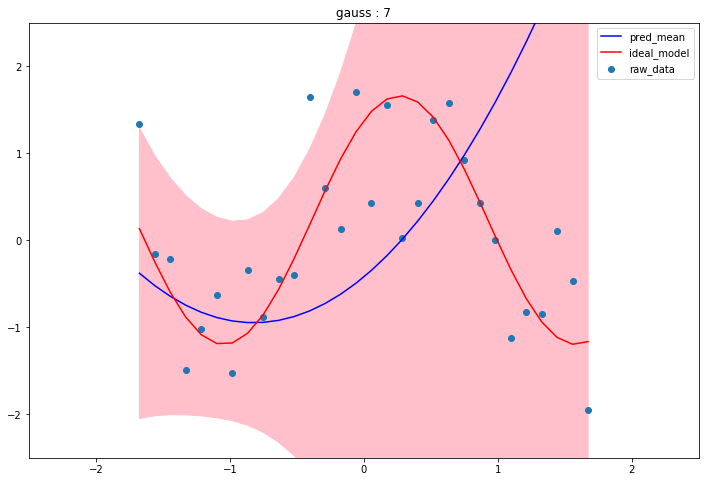

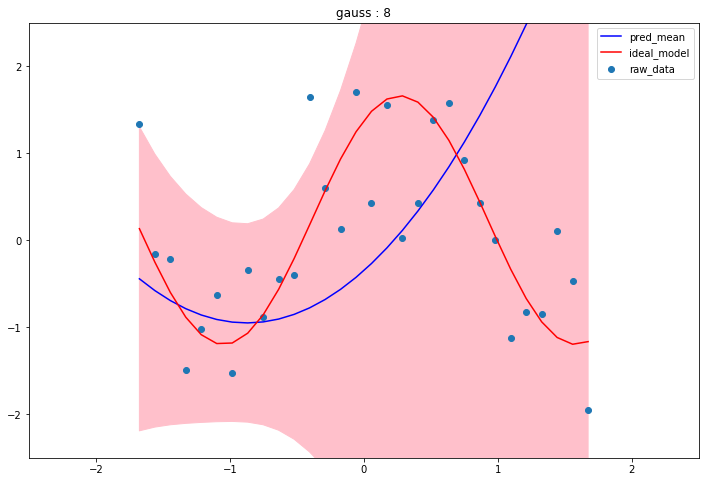

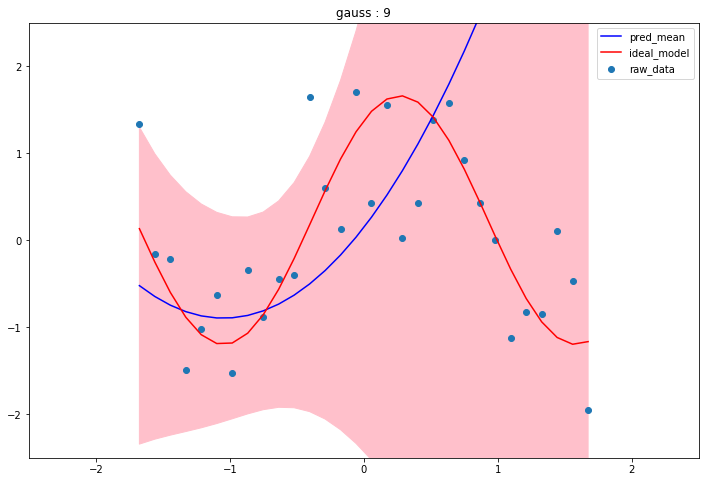

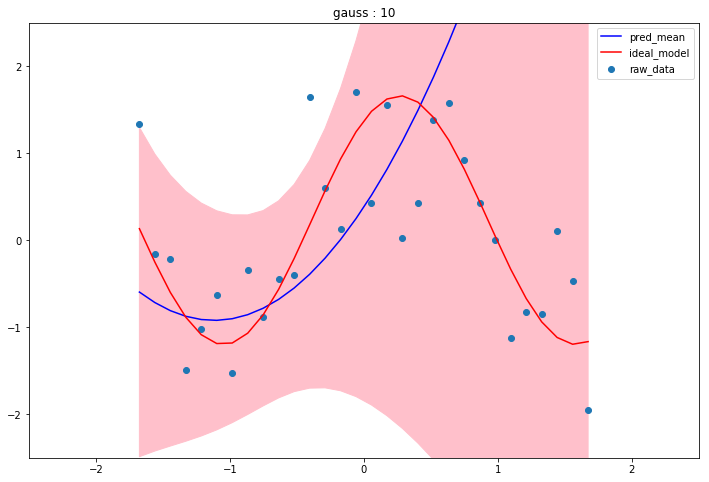

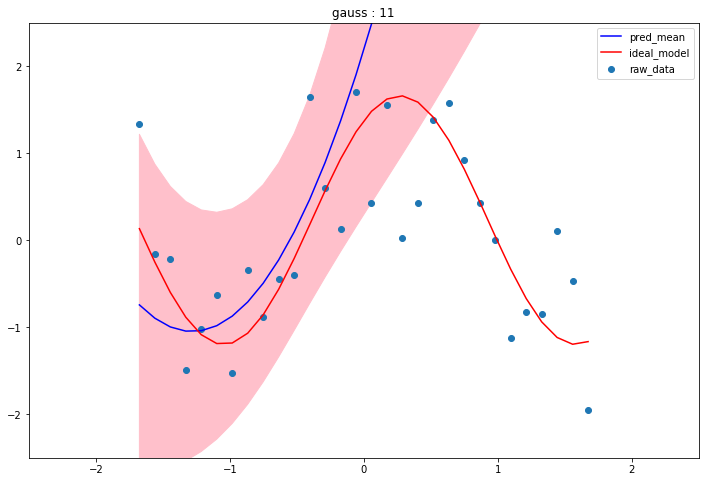

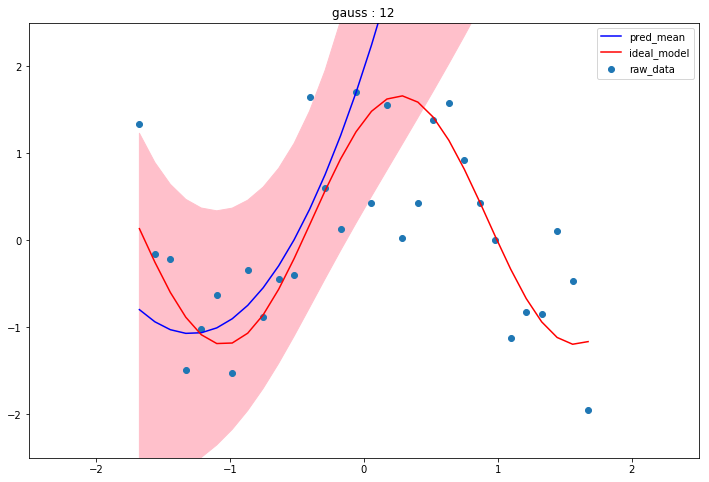

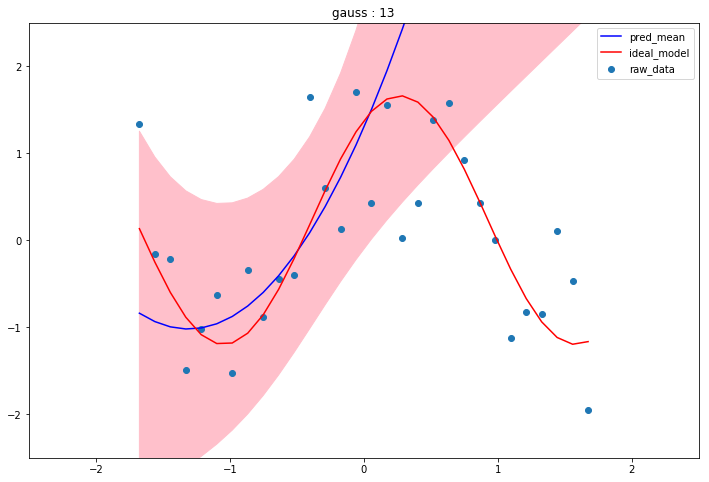

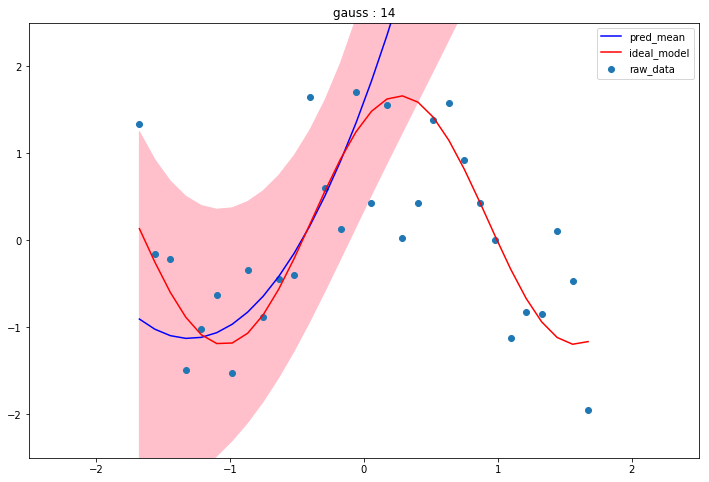

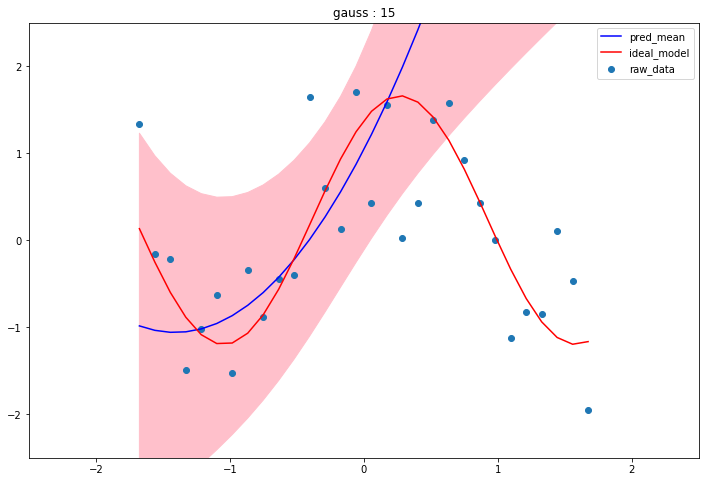

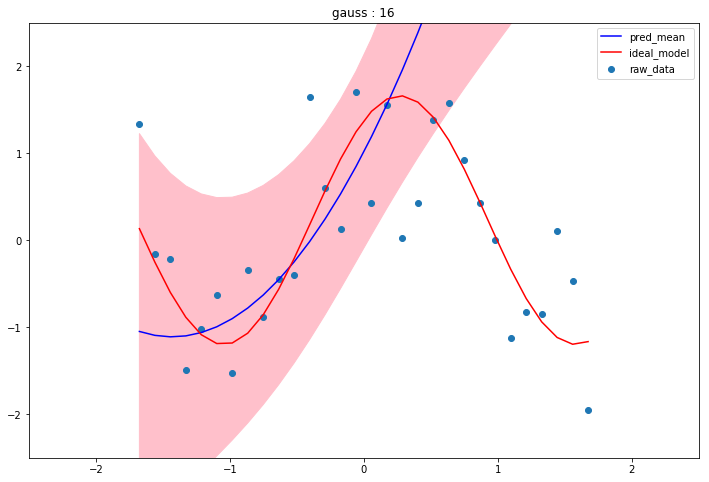

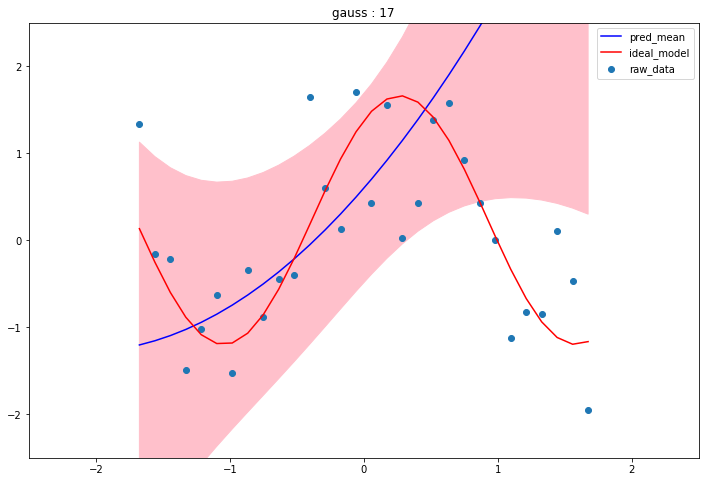

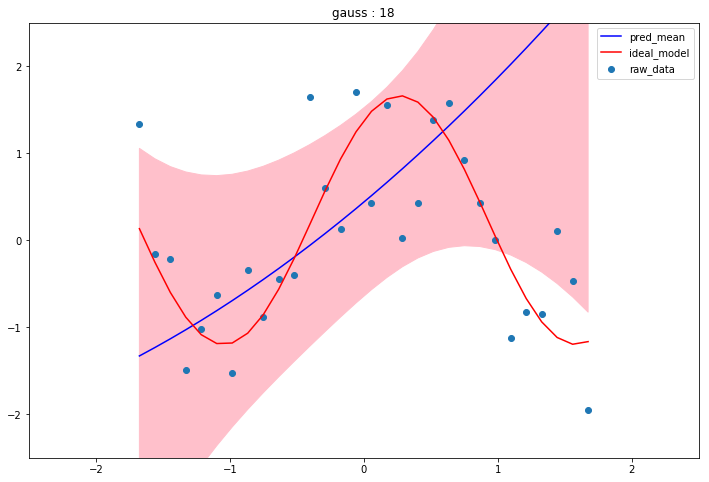

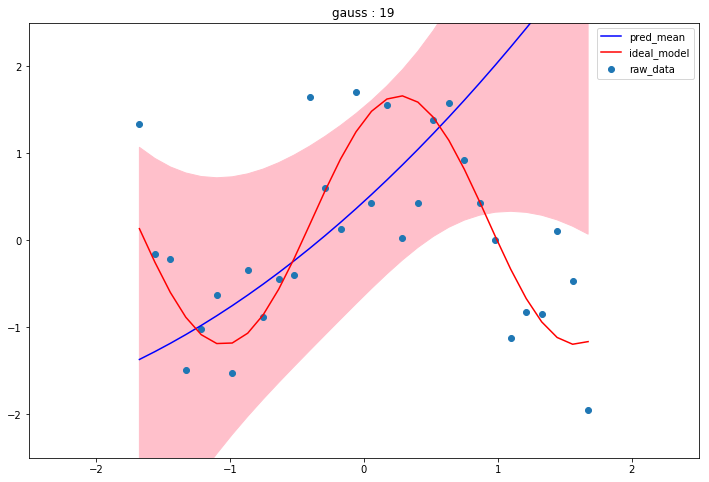

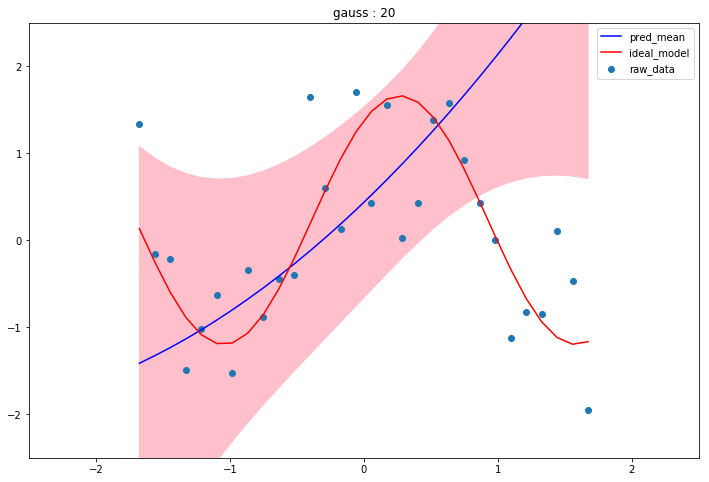

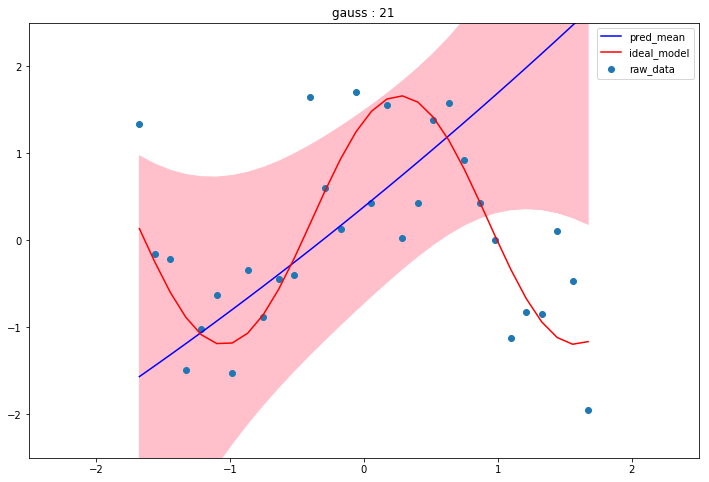

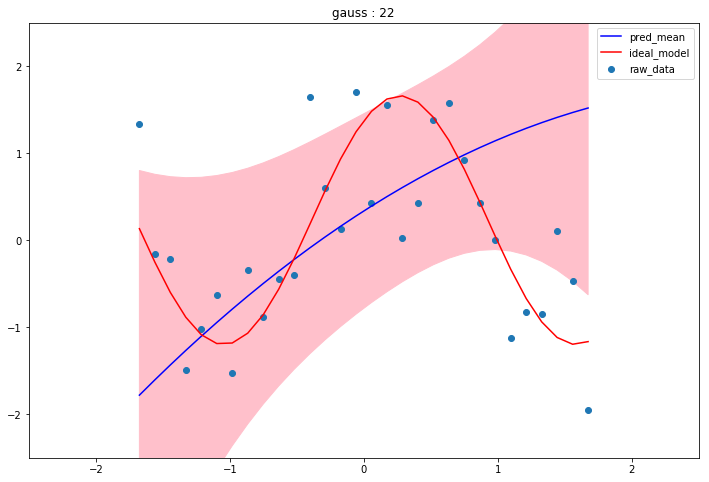

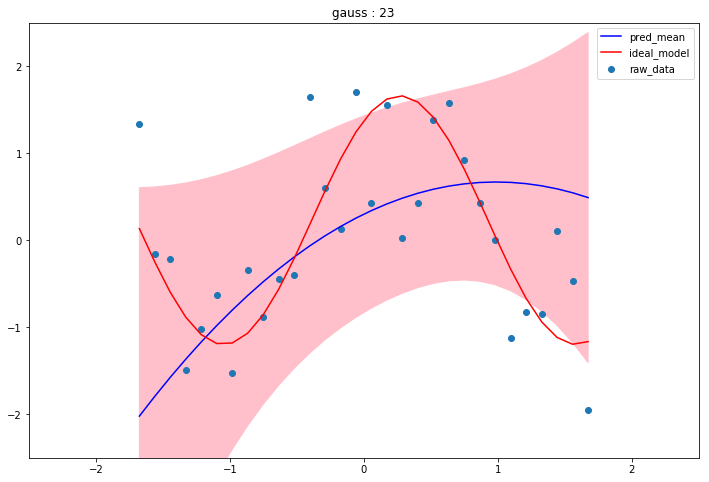

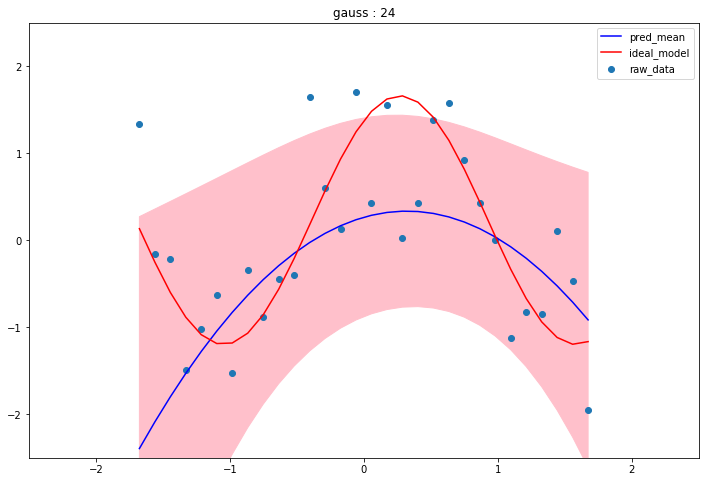

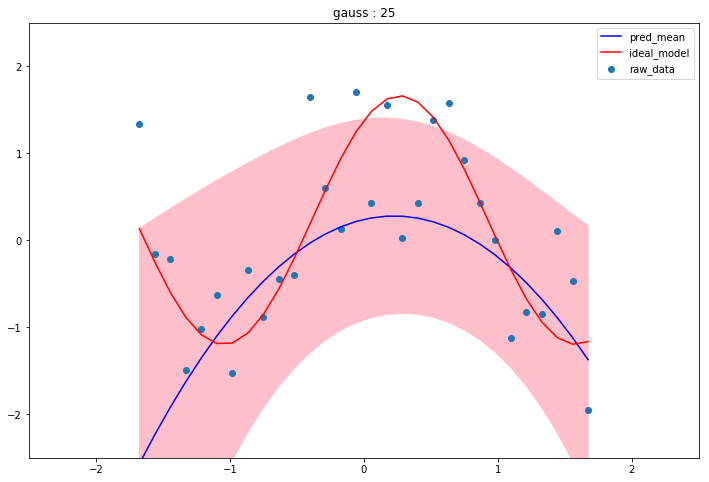

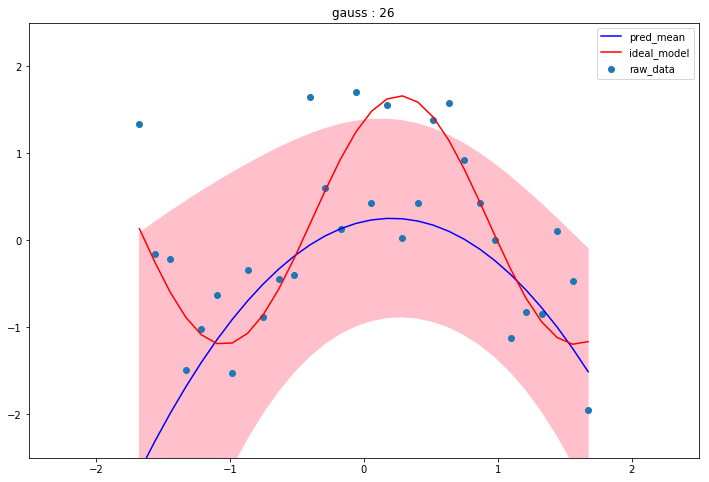

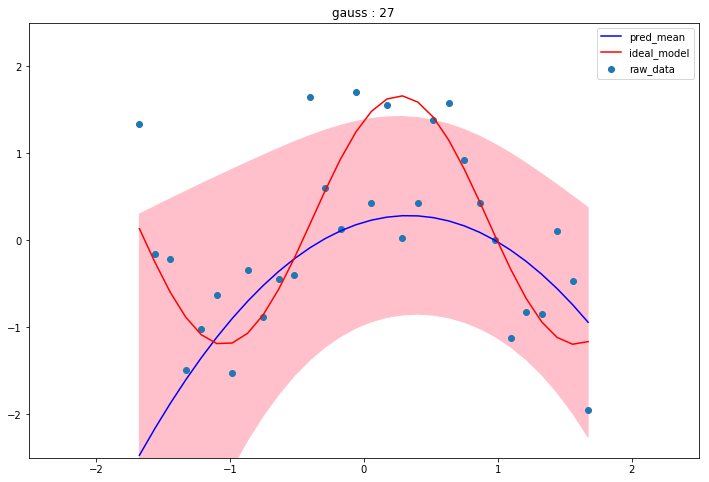

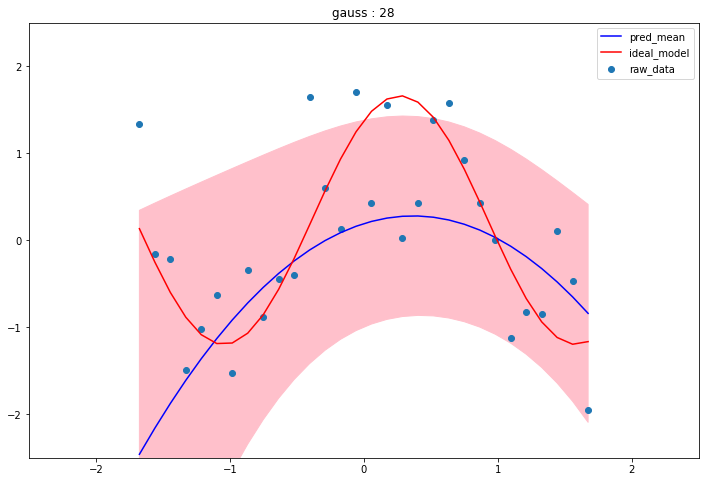

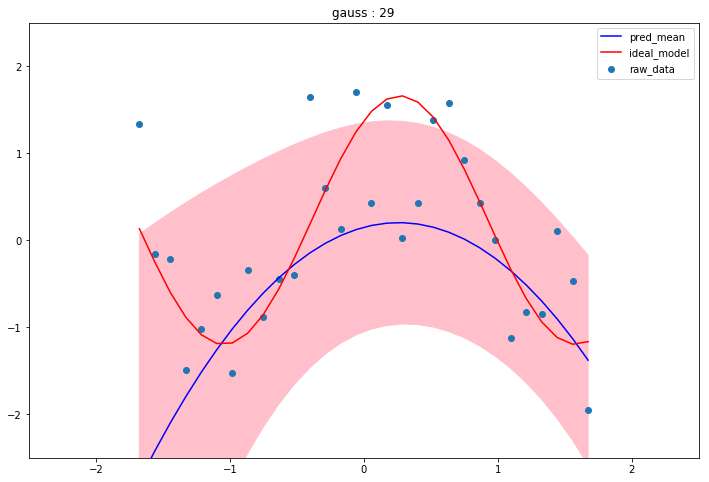

In [45]:
mode = 'gauss'
M = 30
mu = np.linspace(-2,2,M)
wS_list,wm_list, S_list, m_list = bayesian_regression(X, y,M=M,beta=1.0,
                                                     base_mode=mode,
                                                     mu=mu)
for i in range(X.shape[0]):
    plt.figure(figsize=(12,8))
    plt.ylim(-2.5,2.5)
    plt.xlim(-2.5,2.5)
    SD = np.sqrt(np.diag(S_list[i]))
    upper = m_list[i].flatten() + SD.flatten()
    lower = m_list[i].flatten() - SD.flatten()
    plt.fill_between(X.flatten(), upper.flatten(), lower.flatten(), color='pink')
    plt.scatter(X.flatten(),y, label='raw_data')
    plt.plot(X.flatten(), m_list[i].flatten(), label='pred_mean',color='b')
    plt.plot(X.flatten(), y_true, label='ideal_model', color='r')
    plt.legend()
    plt.title(f'{mode} : {i}')
    plt.savefig(f'fig/bayesian_{mode}_{i}.png')
    